In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.models import load_model

Using TensorFlow backend.


### Function Defs

In [3]:
def gen_synth_pulse(amp, T0, wf):
    length = len(wf)
    cc_slow = 2.5+0.4*random.uniform(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=zeros(2);charge=zeros(2);cur_s=zeros(2);cur_f=zeros(2);cr=zeros(2);rc1=zeros(2);rc2=zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return;

In [4]:
def format_data(my_data):
    X = np.empty((len(my_data), 400, 1))
    for i in range(len(my_data)):
        my_data[i] -= np.mean(my_data[i][:800]) 
        my_data[i] = my_data[i]/max(my_data[i])
        X[i][:,0] = my_data[i][800:1200]  
    return X

### Load Model

In [5]:
model = load_model('occam2.h5')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 128)          8320      
_________________________________________________________________
activation_1 (Activation)    (None, 400, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51201     
Total params: 59,521
Trainable params: 59,521
Non-trainable params: 0
_________________________________________________________________


### Sample Sizes

In [7]:
N = int(1e3)

In [8]:
wavelen=3500

### Accuracy when all events are non-pileup events

In [9]:
data = empty((N, wavelen))
for i in range(N):
    gen_synth_pulse(random.randint(200,2500), random.randint(900,1100), data[i])
    data[i] += random.normal(scale=40, loc=0, size=wavelen)

In [10]:
model.evaluate(format_data(data), zeros(N))

1000/1000 [==============================] - 2s 2ms/step


[0.11873566871881484, 0.99]

### Accuracy when all events are pileup events

In [11]:
from threading import Thread

In [12]:
from multiprocessing import cpu_count

In [13]:
data = empty((N, wavelen))
tmp = empty(wavelen)
for i in range(N):
    T0 = random.randint(900,1100)
    E = random.randint(200,2500)
    p = random.random()
    gen_synth_pulse(T0, E*p, tmp)
    gen_synth_pulse(T0+random.randint(2,40),E*(1.-p), data[i])
    data[i] += tmp
    data[i] += random.normal(scale=40, loc=0, size=wavelen)

In [14]:
model.evaluate(format_data(data), ones(N))

1000/1000 [==============================] - 0s 67us/step


[2.557058615684509, 0.749]

### For all Accuracy as Function of x cells, other params are held at avg value

### Accuracy as a function of Energy

In [15]:
acc1 = []
for E in range(200, 2500, 100):
    data = empty((N, wavelen))
    for i in range(N):
        gen_synth_pulse(1000, E*.5, tmp)
        gen_synth_pulse(1020, E*.5, data[i])
        data[i] += tmp
        data[i] += random.normal(scale=40, loc=0, size=wavelen)
    acc1.append(model.evaluate(format_data(data),ones(N),verbose=False)[1]);

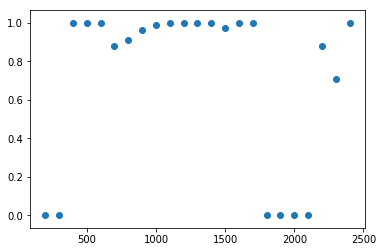

In [16]:
scatter(arange(200,2500,100),acc1)

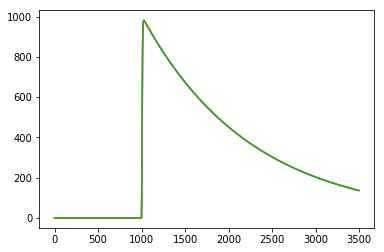

In [43]:
#for E in range(1800, 2300, 100):
E = 2000
data = empty((3, wavelen))
for i in range(3):
    gen_synth_pulse(1000, E*.5, tmp)
    gen_synth_pulse(1020, E*.5, data[i])
    data[i] += tmp
    data[i] += random.normal(scale=40, loc=0, size=wavelen)
    #acc1.append(model.evaluate(format_data(data),ones(N),verbose=False)[1]);

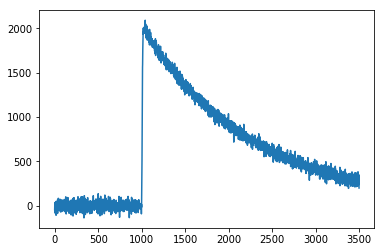

In [38]:
plot(data[0])

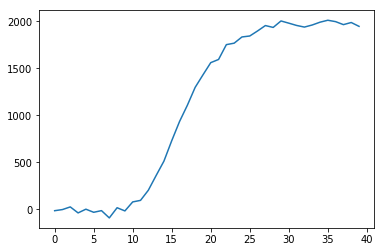

In [39]:
plot(data[0][990:1030])

In [44]:
tmp2 = empty(3500)
gen_synth_pulse(1000, 1000, tmp2)

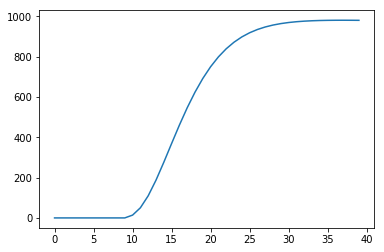

In [46]:
plot(tmp2[990:1030])

In [ ]:
x = format_data(data)

In [36]:
format_data(data).shape

ValueError: could not broadcast input array from shape (0,1) into shape (400)

In [ ]:
plot(data[0])

### Accuracy as a function of $\Delta t_0$

In [17]:
acc2 = []
for del_T0 in range(2,40,3):
    data = empty((N, wavelen))
    for i in range(N):
        gen_synth_pulse(1000, 2300*.25, tmp)
        gen_synth_pulse(1000+del_T0, 2300*.25, data[i])
        data[i] += tmp
        data[i] += random.normal(scale=40, loc=0, size=wavelen)
    acc2.append(model.evaluate(format_data(data),ones(N),verbose=False)[1]);

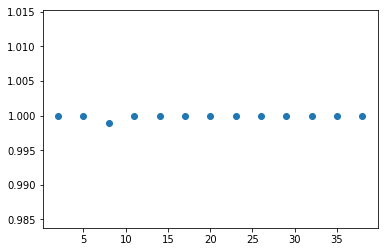

In [18]:
scatter(arange(2,40,3),acc2)

### Accuracy as a function of Percent Initially Deposited

In [19]:
acc3 = []
for p in range(10, 90, 10):
    p *= 1./100
    data = empty((N, wavelen))
    for i in range(N):
        p = random.random()
        gen_synth_pulse(1000, 2300*.5*p, tmp)
        gen_synth_pulse(1020, 2300*.5*(1.-p), data[i])
        data[i] += tmp
        data[i] += random.normal(scale=40, loc=0, size=wavelen)
    acc3.append(model.evaluate(format_data(data),ones(N),verbose=False)[1]);

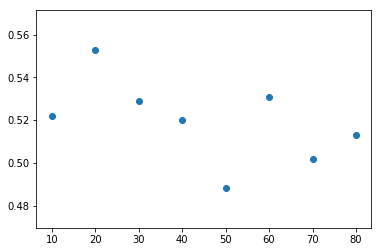

In [20]:
scatter(arange(10,90,10),acc3)